In [2]:
import pickle
import pandas as pd
import numpy as np
import pickle

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time


from tensorflow.keras.callbacks import ReduceLROnPlateau
from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers


from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

### Data loading

In [3]:
def min_max_normalize_rul_by_bearing(data, rul_col='RUL', bearing_col='bearing_id'):
    """
    Effectue une normalisation Min-Max du RUL pour chaque roulement (bearing_id).

    :param data: DataFrame contenant les colonnes `bearing_col` et `rul_col`.
    :param rul_col: Nom de la colonne contenant le RUL brut.
    :param bearing_col: Nom de la colonne contenant les identifiants des roulements.
    :return: DataFrame avec une colonne `RUL_norm` ajoutée.
    """
    data['RUL_norm'] = data.groupby(bearing_col)[rul_col].transform(
        lambda x: round((x - x.min()) / (x.max() - x.min()), 3)
    )
    return data

def create_sequences(data, target_col, sequence_length, remaining_feature):
    """
    Transforme les données en séquences pour les modèles séquentiels.
    :param data: DataFrame trié par temps et bearing_id
    :param target_col: Nom de la colonne cible (RUL)
    :param sequence_length: Longueur de chaque séquence
    :return: Arrays pour X (features) et y (targets)
    """
    X, y = [], []
    for _, group in data.groupby('bearing_id'):  
        targets = group[target_col].values
        col_to_drop = [col for col  in group.columns if col not in remaining_feature]
        group_values = group.drop(columns=col_to_drop).values
        for i in range(len(group_values) - sequence_length):
            X.append(group_values[i:i + sequence_length])
            y.append(targets[i + sequence_length])
    return np.array(X), np.array(y)

def normalize_features_by_bearing(data, feature_cols, bearing_col='bearing_id'):
    """
    Normalise les colonnes des caractéristiques (features) par roulement en utilisant Min-Max.

    :param data: DataFrame contenant les colonnes des caractéristiques et des roulements.
    :param feature_cols: Liste des colonnes des caractéristiques à normaliser.
    :param bearing_col: Nom de la colonne contenant les identifiants des roulements.
    :return: DataFrame avec les colonnes normalisées.
    """
    # Appliquer la normalisation Min-Max à chaque colonne de caractéristiques
    for col in feature_cols:
        data[col] = data.groupby(bearing_col)[col].transform(
            lambda x: (x - x.min()) / (x.max() - x.min())
        )
    return data

def prep_data(train, val, test, remaining_sensors, alpha, drop = True, drop_sensors=None):
    # if drop:
    #     X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    #     X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))
    # else:
    #     X_train_interim = train.rename(columns={'bearing_id': 'op_cond'})
    #     X_test_interim = test.rename(columns={'bearing_id': 'op_cond'})

    X_train_interim = train.rename(columns={'bearing_id': 'op_cond'})
    X_val_interim = val.rename(columns={'bearing_id': 'op_cond'})
    X_test_interim = test.rename(columns={'bearing_id': 'op_cond'})

    
    X_train_interim, X_val_interim, X_test_interim = condition_scaler(X_train_interim, X_val_interim, X_test_interim, remaining_sensors)
    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_val_interim = exponential_smoothing(X_val_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
    
    return X_train_interim, X_val_interim, X_test_interim

def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

def condition_scaler(df_train, df_val, df_test, sensor_names):
      # apply operating condition specific scaling
  #scaler = StandardScaler()
    scaler = StandardScaler()
    # for condition in df_train['op_cond'].unique():
    scaler.fit(df_train.loc[:, sensor_names])
    
    df_train.loc[:, sensor_names] = scaler.transform(df_train.loc[:, sensor_names])
    df_val.loc[:, sensor_names] = scaler.transform(df_val.loc[:, sensor_names])
    df_test.loc[:, sensor_names] = scaler.transform(df_test.loc[:, sensor_names])
    
    return df_train, df_val, df_test

def exponential_smoothing(df, sensors, n_samples, alpha=0.3):
    df = df.copy()
    # first, calculate the exponential weighted mean of desired sensors
    new_column = df.groupby('op_cond')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())
    df[sensors] = new_column.reset_index(level=0, drop=True)


    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('op_cond')['op_cond'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df


In [4]:
remaining_feature = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v"
]
remaining_feature_idx = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v", 'bearing_id']
remaining_feature_rul = [
    "max_abs_h", "moment_11_v", "mean_freq_freq_h", "crest_factor_freq_freq_h", "energy_band_0_freq_h",
    "rms_freq_freq_v", "crest_factor_freq_freq_v", "peak_freq_freq_v", "integral_energy_h",
    "imf_energy_2_tf_h", "imf_rms_3_tf_h", "imf_rms_1_tf_v", "imf_energy_2_tf_v", "imf_rms_3_tf_v",
    "energy_v", "derivative_rms_h", "derivative_margin_factor_h", "derivative_moment_9_h",
    "derivative_mean_v", "derivative_rms_v", "derivative_margin_factor_v", "derivative_moment_7_v", "derivative_moment_8_v",
    "mean_h", "integral_peak_to_peak_h", "integral_rms_h", "integral_form_factor_h", "crest_factor_h",
    "moment_11_h", "integral_moment_9_h", "integral_max_abs_v", "integral_form_factor_v", "integral_crest_factor_v",
    "imf_energy_0_tf_v", "integral_moment_8_v", "integral_moment_7_v", 'bearing_id', 'window_index', 'RUL_norm']

In [5]:
nom_fichier = "df_training.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_training = pickle.load(fichier)
    
    nom_fichier = "df_validation.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_validation = pickle.load(fichier)
    
nom_fichier = "df_test.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_test = pickle.load(fichier)

In [6]:
nom_fichier = "df_training_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_training_rul = pickle.load(fichier)
    
nom_fichier = "df_validation_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_validation_rul = pickle.load(fichier)
    
nom_fichier = "df_test_rul.pkl"

with open(nom_fichier, "rb") as fichier:
    list_df_test_rul = pickle.load(fichier)

### Data preprocessing 

In [7]:
df_train_merged = pd.concat(list_df_training[0:2], ignore_index=True)
df_validation_merged = pd.concat(list_df_validation[0:2], ignore_index=True)
df_test_merged =pd.concat(list_df_test[0:2], ignore_index=True)

df_train_merged_rul = pd.concat(list_df_training_rul[0:2], ignore_index=True)
df_validation_merged_rul = pd.concat(list_df_validation_rul[0:2], ignore_index=True)
df_test_merged_rul =pd.concat(list_df_test_rul[0:2], ignore_index=True)

df_train_merged['RUL'] = df_train_merged_rul['RUL']
df_validation_merged['RUL'] = df_validation_merged_rul['RUL']
df_test_merged['RUL'] = df_test_merged_rul['RUL']

df_train_merged = min_max_normalize_rul_by_bearing(df_train_merged)[remaining_feature_rul]
df_validation_merged = min_max_normalize_rul_by_bearing(df_validation_merged)[remaining_feature_rul]
df_test_merged = min_max_normalize_rul_by_bearing(df_test_merged)[remaining_feature_rul]

In [8]:
    # Créer des séquences pour l’entraînement et la validation
    alpha = 0.2
    X_train_interim, X_val_interim, X_test_interim = prep_data(train=df_train_merged[remaining_feature_idx],
                                                            val=df_validation_merged[remaining_feature_idx], 
                                                            test=df_test_merged[remaining_feature_idx], 
                                                            remaining_sensors=remaining_feature, 
                                                            alpha=alpha, drop=False)
    X_train, X_val, X_test =  X_train_interim.loc[:, remaining_feature], X_val_interim.loc[:, remaining_feature],  X_test_interim.loc[:, remaining_feature]
    y_train, y_val, y_test = df_train_merged['RUL_norm'], df_validation_merged['RUL_norm'], df_test_merged['RUL_norm']

In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, root_mean_squared_error

# Création du modèle XGBoost
model = xgb.XGBRegressor()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation de la performance du modèle
accuracy = root_mean_squared_error(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.28669262340408963


In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Vérifiez les données
# assert not np.isnan(X_train).any(), "X_train contains NaN values"
# assert not np.isnan(y_train).any(), "y_train contains NaN values"

# Modèle XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42)

# Réduction de l'espace des hyperparamètres
param_grid = {
    'n_estimators': [50, 100, 200],       # Nombre d'arbres
    'max_depth': [3, 6, 10],             # Profondeur maximale
    'learning_rate': [0.01, 0.1, 0.2],   # Taux d'apprentissage
    'min_child_weight': [1, 5, 10],      # Nombre minimal d'échantillons par nœud
    'subsample': [0.6, 0.8, 1.0],        # Sous-échantillonnage des données
    'colsample_bytree': [0.6, 0.8, 1.0]  # Sous-échantillonnage des colonnes
}

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    error_score='raise'  # Afficher les erreurs spécifiques
)

# Lancer la recherche
print("Lancement de Grid Search...")
grid_result = grid_search.fit(X_train, y_train)

# Résultats
print(f"\nMeilleurs paramètres trouvés : {grid_result.best_params_}")
print(f"Meilleure erreur quadratique moyenne (validation) : {np.sqrt(-grid_result.best_score_)}")

Lancement de Grid Search...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits

Meilleurs paramètres trouvés : {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1.0}
Meilleure erreur quadratique moyenne (validation) : 0.2873792251934265


In [19]:
# Récupérer les meilleurs paramètres trouvés
best_params = grid_result.best_params_
print("Meilleurs paramètres :", best_params)

best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

# Entraîner le modèle sur l'ensemble d'entraînement
best_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = best_model.predict(X_test)

# Calculer les métriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nPerformance du modèle optimal sur l'ensemble de test :")
print(f" - RMSE : {rmse}")
print(f" - R^2 : {r2}")

Meilleurs paramètres : {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1.0}

Performance du modèle optimal sur l'ensemble de test :
 - RMSE : 0.28658593548554295
 - R^2 : 0.0220280430694223


In [21]:
y_pred = best_model.predict(X_test)

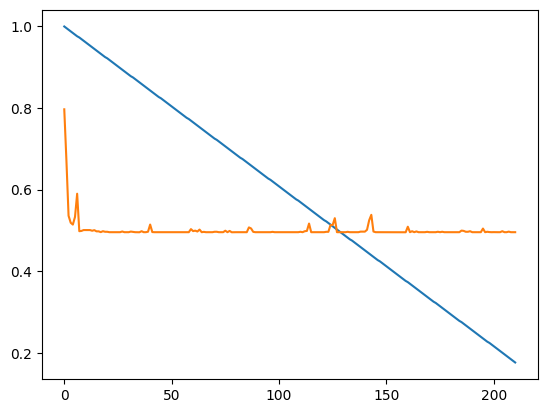

In [22]:
plt.plot(y_test[:211])
plt.plot(y_pred[:211])

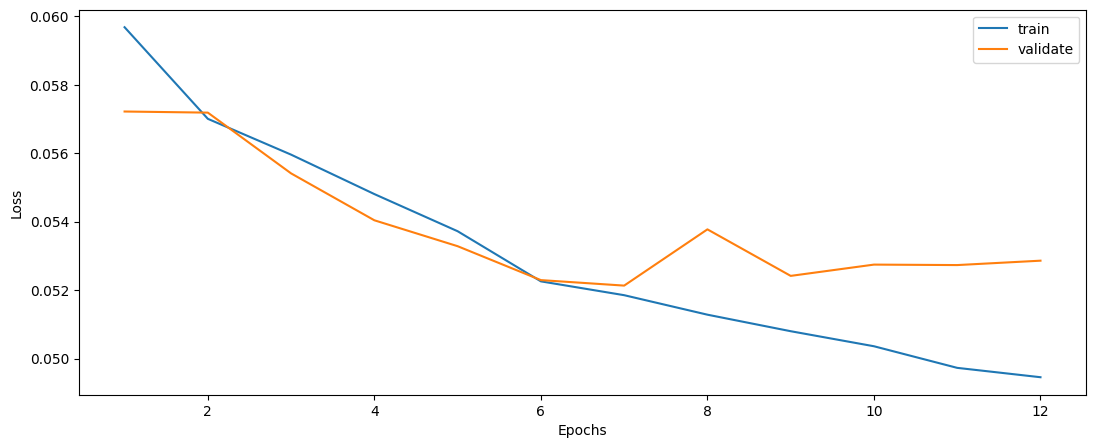

In [38]:
plot_loss(history)